## Import libraries and load raw NewHandPD Dataset

In [1]:
import os
from collections import defaultdict
from itertools import product
import random
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import ColorJitter
import torch.optim as optim


In [3]:
dataset_path = '/kaggle/input/newhandpd'

categories = os.listdir(dataset_path)

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
        print(f"{category}: {num_images} images")

PatientSpiral: 124 images
HealthyCircle: 35 images
PatientMeander: 124 images
HealthyMeander: 140 images
HealthySpiral: 140 images
PatientCircle: 31 images


## Data pre-processing
### Image pairs formation and splitting in training, validation, test datasets

In [5]:
# Dataset path
dataset_path = '/kaggle/input/newhandpd'

# Extract image_id and person_id from filename
def extract_ids(filename):
    base = os.path.splitext(filename)[0]  
    parts = base.split('-')
    if len(parts) == 2:
        return parts[0], parts[1] 
    return None, None

# Get all Spiral-Meander pairs, grouped by person_id
def get_pairs_by_person(group_prefix):
    spiral_path = os.path.join(dataset_path, f"{group_prefix}Spiral")
    meander_path = os.path.join(dataset_path, f"{group_prefix}Meander")

    spiral_dict = defaultdict(list)
    meander_dict = defaultdict(list)

    for fname in os.listdir(spiral_path):
        _, person_id = extract_ids(fname)
        if person_id:
            spiral_dict[person_id].append(os.path.join(f"{group_prefix}Spiral", fname))

    for fname in os.listdir(meander_path):
        _, person_id = extract_ids(fname)
        if person_id:
            meander_dict[person_id].append(os.path.join(f"{group_prefix}Meander", fname))

    person_to_pairs = defaultdict(list)
    for person_id in spiral_dict:
        if person_id in meander_dict:
            pairs = list(product(spiral_dict[person_id], meander_dict[person_id]))
            person_to_pairs[person_id].extend(pairs)

    return person_to_pairs

# Split person_id keys into train/val/test sets
def split_by_individuals(person_to_pairs, seed=42):
    person_ids = list(person_to_pairs.keys())
    random.seed(seed)
    random.shuffle(person_ids)

    total = len(person_ids)
    n_train = int(0.7 * total)
    n_val = int(0.15 * total)

    train_ids = person_ids[:n_train]
    val_ids = person_ids[n_train:n_train+n_val]
    test_ids = person_ids[n_train+n_val:]

    train_pairs = [pair for pid in train_ids for pair in person_to_pairs[pid]]
    val_pairs = [pair for pid in val_ids for pair in person_to_pairs[pid]]
    test_pairs = [pair for pid in test_ids for pair in person_to_pairs[pid]]

    return train_pairs, val_pairs, test_pairs

# Apply it to both groups
healthy_pairs_by_person = get_pairs_by_person("Healthy")
patient_pairs_by_person = get_pairs_by_person("Patient")

healthy_train, healthy_val, healthy_test = split_by_individuals(healthy_pairs_by_person)
patient_train, patient_val, patient_test = split_by_individuals(patient_pairs_by_person)

# Summary
print("Healthy:")
print(f"  Train: {len(healthy_train)} pairs")
print(f"  Val:   {len(healthy_val)} pairs")
print(f"  Test:  {len(healthy_test)} pairs")

print("\nPatient:")
print(f"  Train: {len(patient_train)} pairs")
print(f"  Val:   {len(patient_val)} pairs")
print(f"  Test:  {len(patient_test)} pairs")


Healthy:
  Train: 384 pairs
  Val:   80 pairs
  Test:  96 pairs

Patient:
  Train: 336 pairs
  Val:   64 pairs
  Test:  96 pairs


### Dataset building for original image pairs and for data augmentation (horizontal flipping, vertical flipping, contrast and illumination)

In [6]:
class Dataset_no_data_aug(Dataset):
    def __init__(self, pairs, root_dir, label, img_size=(128, 128)):
        self.pairs = pairs
        self.root_dir = root_dir
        self.label = label
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        spiral_path, meander_path = self.pairs[idx]
        
        spiral_img = Image.open(os.path.join(self.root_dir, spiral_path)).convert("RGB")
        meander_img = Image.open(os.path.join(self.root_dir, meander_path)).convert("RGB")

        # Resize to 128x128 dimensions
        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Save in tensor
        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        # Normalization
        mean = [0.485, 0.456, 0.406]  
        std = [0.229, 0.224, 0.225]  
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y


class Dataset_hflip(Dataset):
    def __init__(self, pairs, root_dir, label, img_size=(128, 128)):
        self.root_dir = root_dir
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_flip = self.expanded_pairs[idx]
        spiral_img = Image.open(os.path.join(self.root_dir, spiral_path)).convert("RGB")
        meander_img = Image.open(os.path.join(self.root_dir, meander_path)).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply horizontal flipping
        if apply_flip:
            spiral_img = TF.hflip(spiral_img)
            meander_img = TF.hflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_vflip(Dataset):
    def __init__(self, pairs, root_dir, label, img_size=(128, 128)):
        self.root_dir = root_dir
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_flip = self.expanded_pairs[idx]
        spiral_img = Image.open(os.path.join(self.root_dir, spiral_path)).convert("RGB")
        meander_img = Image.open(os.path.join(self.root_dir, meander_path)).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply vertical flipping
        if apply_flip:
            spiral_img = TF.vflip(spiral_img)
            meander_img = TF.vflip(meander_img)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y



class Dataset_contrast(Dataset):
    def __init__(self, pairs, root_dir, label, img_size=(128, 128), contrast_factor_range=(0.5, 1.5)):
        self.root_dir = root_dir
        self.label = label
        self.img_size = img_size
        self.contrast_factor_range = contrast_factor_range  # Range for contrast adjustment
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_contrast = self.expanded_pairs[idx]
        spiral_img = Image.open(os.path.join(self.root_dir, spiral_path)).convert("RGB")
        meander_img = Image.open(os.path.join(self.root_dir, meander_path)).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply contrast augmentation
        if apply_contrast:
            contrast_factor = random.uniform(*self.contrast_factor_range)
            spiral_img = TF.adjust_contrast(spiral_img, contrast_factor)
            meander_img = TF.adjust_contrast(meander_img, contrast_factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y

class Dataset_illumination(Dataset):
    def __init__(self, pairs, root_dir, label, img_size=(128, 128)):
        self.root_dir = root_dir
        self.label = label
        self.img_size = img_size
        self.expanded_pairs = [(pair, False) for pair in pairs] + [(pair, True) for pair in pairs]

    def __len__(self):
        return len(self.expanded_pairs)

    def __getitem__(self, idx):
        (spiral_path, meander_path), apply_illum = self.expanded_pairs[idx]
        spiral_img = Image.open(os.path.join(self.root_dir, spiral_path)).convert("RGB")
        meander_img = Image.open(os.path.join(self.root_dir, meander_path)).convert("RGB")

        spiral_img = TF.resize(spiral_img, self.img_size)
        meander_img = TF.resize(meander_img, self.img_size)

        # Apply illumination augmentation
        if apply_illum:
            factor = random.uniform(0.6, 1.4)
            spiral_img = TF.adjust_brightness(spiral_img, factor)
            meander_img = TF.adjust_brightness(meander_img, factor)

        spiral_img = TF.to_tensor(spiral_img)
        meander_img = TF.to_tensor(meander_img)

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        spiral_img = TF.normalize(spiral_img, mean, std)
        meander_img = TF.normalize(meander_img, mean, std)

        y = torch.tensor(self.label, dtype=torch.long)
        return spiral_img, meander_img, y



### Combine healthy and PD labeled image pair datasets

In [7]:
def create_dataset_no_data_aug(pairs_healthy, pairs_patient, root_dir, img_size=(128, 128)):
    dataset = (
        Dataset_no_data_aug(pairs_healthy, root_dir=root_dir, label=0,
                          img_size=img_size) +
        Dataset_no_data_aug(pairs_patient, root_dir=root_dir, label=1,
                          img_size=img_size)
    )
    return dataset


def create_dataset_hflip(pairs_healthy, pairs_patient, root_dir, img_size=(128, 128)):
    dataset = (
        Dataset_hflip(pairs_healthy, root_dir=root_dir, label=0,
                          img_size=img_size) +
        Dataset_hflip(pairs_patient, root_dir=root_dir, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_vflip(pairs_healthy, pairs_patient, root_dir, img_size=(128, 128)):
    dataset = (
        Dataset_vflip(pairs_healthy, root_dir=root_dir, label=0,
                          img_size=img_size) +
        Dataset_vflip(pairs_patient, root_dir=root_dir, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_contrast(pairs_healthy, pairs_patient, root_dir, img_size=(128, 128)):
    dataset = (
        Dataset_contrast(pairs_healthy, root_dir=root_dir, label=0,
                          img_size=img_size) +
        Dataset_contrast(pairs_patient, root_dir=root_dir, label=1,
                          img_size=img_size)
    )
    return dataset

def create_dataset_illumination(pairs_healthy, pairs_patient, root_dir, img_size=(128, 128)):
    dataset = (
        Dataset_illumination(pairs_healthy, root_dir=root_dir, label=0,
                          img_size=img_size) +
        Dataset_illumination(pairs_patient, root_dir=root_dir, label=1,
                          img_size=img_size)
    )
    return dataset

train_dataset = create_dataset_no_data_aug(healthy_train, patient_train, dataset_path, img_size=(128,128))
val_dataset   = create_dataset_no_data_aug(healthy_val, patient_val, dataset_path, img_size=(128,128))
test_dataset  = create_dataset_no_data_aug(healthy_test, patient_test, dataset_path, img_size=(128,128))

train_dataset_hflip = create_dataset_hflip(healthy_train, patient_train, dataset_path, img_size=(128,128))
train_dataset_vflip = create_dataset_vflip(healthy_train, patient_train, dataset_path, img_size=(128,128))
train_dataset_contrast = create_dataset_contrast(healthy_train, patient_train, dataset_path, img_size=(128,128))
train_dataset_illumination = create_dataset_illumination(healthy_train, patient_train, dataset_path, img_size=(128,128))

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(len(train_dataset_hflip))
print(len(train_dataset_vflip))
print(len(train_dataset_contrast))
print(len(train_dataset_illumination))

720
144
192
1440
1440
1440
1440


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader_hflip = DataLoader(train_dataset_hflip, batch_size=32, shuffle=True)
train_loader_vflip = DataLoader(train_dataset_vflip, batch_size=32, shuffle=True)
train_loader_contrast = DataLoader(train_dataset_contrast, batch_size=32, shuffle=True)
train_loader_illumination = DataLoader(train_dataset_illumination, batch_size=32, shuffle=True)

## Definition of the 5 multimodal architectures investigated

In [7]:
class LateFusionResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(LateFusionResNet, self).__init__()
        # Load pretrained ResNet18s
        self.spiral_net = models.resnet18(pretrained=True)
        self.wave_net = models.resnet18(pretrained=True)

        # Remove final FC layers
        self.spiral_net = nn.Sequential(*list(self.spiral_net.children())[:-1])  
        self.wave_net = nn.Sequential(*list(self.wave_net.children())[:-1])

        # Classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, spiral_img, wave_img):
        # Pass each modality through its corresponding resnet18
        spiral_feat = self.spiral_net(spiral_img)
        wave_feat = self.wave_net(wave_img)

        # Concatenate features
        combined = torch.cat((spiral_feat, wave_feat), dim=1)
        
        # Apply classifier
        output = self.classifier(combined)
        return output

In [8]:
class EarlyFusionResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EarlyFusionResNet, self).__init__()
        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)

        # Modify first conv layer to accept 6 input channels instead of 3
        orig_conv = self.base_model.conv1
        self.base_model.conv1 = nn.Conv2d(
            in_channels=6,
            out_channels=orig_conv.out_channels,
            kernel_size=orig_conv.kernel_size,
            stride=orig_conv.stride,
            padding=orig_conv.padding,
            bias=orig_conv.bias is not None
        )

        # Initialize new conv weights by copying existing 3-channel weights
        with torch.no_grad():
            self.base_model.conv1.weight[:, :3] = orig_conv.weight
            self.base_model.conv1.weight[:, 3:] = orig_conv.weight.clone()

        # Classifier
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, spiral_img, meander_img):
        
        # Concatenate modalities along the channel axis
        fused_input = torch.cat((spiral_img, meander_img), dim=1)

        # Apply Early Fusion model
        return self.base_model(fused_input)


In [9]:
class IntermediateFusionResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(IntermediateFusionResNet, self).__init__()

        # Load pretrained ResNet18s
        base_spiral = models.resnet18(pretrained=True)
        base_meander = models.resnet18(pretrained=True)
        base_shared = models.resnet18(pretrained=True)

        # Separate early layers up to layer3
        self.spiral_early = nn.Sequential(
            base_spiral.conv1,
            base_spiral.bn1,
            base_spiral.relu,
            base_spiral.maxpool,
            base_spiral.layer1,
            base_spiral.layer2,
            base_spiral.layer3
        )

        self.meander_early = nn.Sequential(
            base_meander.conv1,
            base_meander.bn1,
            base_meander.relu,
            base_meander.maxpool,
            base_meander.layer1,
            base_meander.layer2,
            base_meander.layer3
        )

        self.reduce_spiral = nn.Linear(256, 128)
        self.reduce_meander = nn.Linear(256, 128)

        # Late resnet18 after fusion
        self.shared_late = nn.Sequential(
            base_shared.layer4,
            base_shared.avgpool
        )

        # Classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, spiral_img, meander_img):
        # Early feature extraction
        spiral_feat = self.spiral_early(spiral_img)     
        meander_feat = self.meander_early(meander_img)  
    
        # Global Average Pooling
        spiral_feat = torch.nn.functional.adaptive_avg_pool2d(spiral_feat, (1, 1)).squeeze(-1).squeeze(-1) 
        meander_feat = torch.nn.functional.adaptive_avg_pool2d(meander_feat, (1, 1)).squeeze(-1).squeeze(-1)
    
        # Dimensionality reduction
        spiral_feat = self.reduce_spiral(spiral_feat)  
        meander_feat = self.reduce_meander(meander_feat)
    
        # Intermediate fusion 
        fused_feat = torch.cat((spiral_feat, meander_feat), dim=1)  
        fused_feat = fused_feat.unsqueeze(-1).unsqueeze(-1)  
    
        # Late ResNet18 layers
        fused_feat = self.shared_late(fused_feat)  
    
        # Classifier
        out = self.classifier(fused_feat)  
        return out



In [10]:
class CrossAttentionTransformer(nn.Module):
    def __init__(self, num_classes=10, embed_size=256, num_heads=8, num_layers=4):
        super(CrossAttentionTransformer, self).__init__()
        
        # Load pretrained ResNet18s (and remove the classifier layer)
        self.spiral_cnn = models.resnet18(pretrained=True)
        self.spiral_cnn.fc = nn.Identity() 
        self.meander_cnn = models.resnet18(pretrained=True)
        self.meander_cnn.fc = nn.Identity()  
        
        # Linear layer to match feature size for cross-attention
        self.reduce_spiral = nn.Linear(512, embed_size)  
        self.reduce_meander = nn.Linear(512, embed_size)
        
        # Cross-Attention Transformer block
        self.transformer = nn.Transformer(
            d_model=embed_size, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers
        )
        
        # Classifier
        self.classifier = nn.Linear(embed_size, num_classes)
    
    def forward(self, spiral_img, meander_img):
        # Pass each modality through its corresponding resnet18
        spiral_feat = self.spiral_cnn(spiral_img)  
        meander_feat = self.meander_cnn(meander_img)  
        
        # Reduce the feature size for attention
        spiral_feat = self.reduce_spiral(spiral_feat) 
        meander_feat = self.reduce_meander(meander_feat) 
        
        # Apply the transformer for cross-attention (Pass spiral as query and meander as key/value)
        spiral_feat = spiral_feat.unsqueeze(0)  
        meander_feat = meander_feat.unsqueeze(0)  
        
        output = self.transformer(spiral_feat, meander_feat)
        output = output.squeeze(0)  
        
        # Classifier
        out = self.classifier(output) 
        
        return out


In [11]:
class CoAttentionBlock(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(CoAttentionBlock, self).__init__()
        self.query_proj_s = nn.Linear(embed_size, embed_size)
        self.key_proj_m = nn.Linear(embed_size, embed_size)
        self.value_proj_m = nn.Linear(embed_size, embed_size)

        self.query_proj_m = nn.Linear(embed_size, embed_size)
        self.key_proj_s = nn.Linear(embed_size, embed_size)
        self.value_proj_s = nn.Linear(embed_size, embed_size)

        self.attn_s_to_m = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)
        self.attn_m_to_s = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

    def forward(self, spiral, meander):
        # spiral attends to meander
        query_s = self.query_proj_s(spiral)
        key_m = self.key_proj_m(meander)
        value_m = self.value_proj_m(meander)
        attn_s, _ = self.attn_s_to_m(query_s, key_m, value_m)

        # meander attends to spiral
        query_m = self.query_proj_m(meander)
        key_s = self.key_proj_s(spiral)
        value_s = self.value_proj_s(spiral)
        attn_m, _ = self.attn_m_to_s(query_m, key_s, value_s)

        return attn_s, attn_m

class CoAttentionModel(nn.Module):
    def __init__(self, num_classes=10, embed_size=256, num_heads=4):
        super(CoAttentionModel, self).__init__()
        # Load pretrained ResNet18s (and remove the classifier layer)
        self.spiral_cnn = models.resnet18(pretrained=True)
        self.spiral_cnn.fc = nn.Identity()

        self.meander_cnn = models.resnet18(pretrained=True)
        self.meander_cnn.fc = nn.Identity()

        # Linear projections to reduce dimensionality
        self.reduce_spiral = nn.Linear(512, embed_size)
        self.reduce_meander = nn.Linear(512, embed_size)

        # Co-Attention Block
        self.co_attention = CoAttentionBlock(embed_size=embed_size, num_heads=num_heads)

        # Classifier
        self.classifier = nn.Linear(embed_size * 2, num_classes)

    def forward(self, spiral_img, meander_img):
        # Pass each modality through its corresponding resnet18
        spiral_feat = self.spiral_cnn(spiral_img) 
        meander_feat = self.meander_cnn(meander_img)  

        # Project to embed size
        spiral_feat = self.reduce_spiral(spiral_feat).unsqueeze(1)  
        meander_feat = self.reduce_meander(meander_feat).unsqueeze(1)  

        # Co-Attention block
        attn_spiral, attn_meander = self.co_attention(spiral_feat, meander_feat) 

        # Fuse bidirectional attention and classify
        fused = torch.cat([attn_spiral.squeeze(1), attn_meander.squeeze(1)], dim=-1)  
        out = self.classifier(fused)
        return out


In [10]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
Device name: Tesla T4


## Define training and testing functions

In [11]:
def evaluate_model(model, val_loader, device):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():  
        for spiral_img, meander_img, labels in val_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(spiral_img, meander_img)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)

            # Update correct and total counters
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

def train_model(model, train_loader, val_loader, epochs=10, device=None):
    model.train()
    for epoch in range(epochs):
        train_loss, correct, total = 0.0, 0, 0

        for spiral_img, meander_img, labels in train_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Zero the gradients before running the backward pass
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(spiral_img, meander_img)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate and update weights
            loss.backward()
            optimizer.step()

            # Accumulate the loss and calculate accuracy
            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        val_accuracy = evaluate_model(model, val_loader, device)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/total:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


In [12]:
def test_model(model, test_loader, device):
    model.eval()  
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  
        for spiral_img, meander_img, labels in test_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Forward pass
            outputs = model(spiral_img, meander_img)

            # Get predicted class labels
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute final accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, all_predictions, all_labels


## Architecture and Augmentation Evaluation

In [63]:
accuracy_list = []

# 5 architectures tested
model_classes = {
    "LateFusionResNet": LateFusionResNet,
    "EarlyFusionResNet": EarlyFusionResNet,
    "IntermediateFusionResNet": IntermediateFusionResNet,
    "CrossAttentionTransformer": CrossAttentionTransformer,
    "CoAttentionModel": CoAttentionModel
}

# 5 Training dataset tested
train_loaders = {
    "Original": train_loader,
    "Horizontal Flip": train_loader_hflip,
    "Vertical Flip": train_loader_vflip,
    "Contrast": train_loader_contrast,
    "Illumination": train_loader_illumination
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define for each architecture the best performing configuration
for model_name, model_class in model_classes.items():
    print(f"\n=== Training {model_name} ===\n")
    accuracies = []

    for augmentation_type, loader in train_loaders.items():
        print(f"--- Training with {augmentation_type} augmentation ---\n")
        
        # Reinitialize model for each augmentation type
        model = model_class(num_classes=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        train_model(model, loader, val_loader, epochs=10, device=device)
        accuracy, all_predictions, all_labels = test_model(model, test_loader, device)
        accuracies.append(accuracy)

    accuracy_list.append(accuracies)    

    
print(accuracy_list)




=== Training LateFusionResNet ===

--- Training with Original augmentation ---



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Loss: 0.2378, Train Acc: 0.9111, Val Acc: 1.0000
Epoch [2/10] - Loss: 0.1019, Train Acc: 0.9736, Val Acc: 0.8125
Epoch [3/10] - Loss: 0.0240, Train Acc: 0.9903, Val Acc: 0.9931
Epoch [4/10] - Loss: 0.0048, Train Acc: 0.9986, Val Acc: 0.9097
Epoch [5/10] - Loss: 0.1537, Train Acc: 0.9597, Val Acc: 0.9792
Epoch [6/10] - Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.9931
Epoch [7/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [8/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [9/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [10/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Test Accuracy: 0.9688
--- Training with Horizontal Flip augmentation ---

Epoch [1/10] - Loss: 0.1606, Train Acc: 0.9403, Val Acc: 1.0000
Epoch [2/10] - Loss: 0.3539, Train Acc: 0.8653, Val Acc: 1.0000
Epoch [3/10] - Loss: 0.1054, Train Acc: 0.9576, Val Acc: 0.9722
Epoch [4/10] - Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.9444
Epoch [5/10] - Loss: 0.0003, 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/10] - Loss: 0.1483, Train Acc: 0.9361, Val Acc: 0.9097
Epoch [2/10] - Loss: 0.6620, Train Acc: 0.7681, Val Acc: 0.9444
Epoch [3/10] - Loss: 0.0878, Train Acc: 0.9736, Val Acc: 0.9722
Epoch [4/10] - Loss: 0.1613, Train Acc: 0.9319, Val Acc: 0.8056
Epoch [5/10] - Loss: 0.0600, Train Acc: 0.9806, Val Acc: 0.8333
Epoch [6/10] - Loss: 0.1579, Train Acc: 0.9667, Val Acc: 0.8611
Epoch [7/10] - Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.8611
Epoch [8/10] - Loss: 0.0014, Train Acc: 1.0000, Val Acc: 0.8611
Epoch [9/10] - Loss: 0.0008, Train Acc: 1.0000, Val Acc: 0.8611
Epoch [10/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.8611
Test Accuracy: 0.9167
--- Training with Horizontal Flip augmentation ---

Epoch [1/10] - Loss: 0.1413, Train Acc: 0.9368, Val Acc: 0.9167
Epoch [2/10] - Loss: 0.1858, Train Acc: 0.9299, Val Acc: 0.9722
Epoch [3/10] - Loss: 0.0969, Train Acc: 0.9688, Val Acc: 1.0000
Epoch [4/10] - Loss: 0.0543, Train Acc: 0.9812, Val Acc: 0.9722
Epoch [5/10] - Loss: 0.0009, 

### Display results

In [9]:
accuracy_list = [[0.96875, 0.96875, 0.9166666666666666, 0.9791666666666666, 0.9791666666666666], 
                 [0.9895833333333334, 0.921875, 0.9739583333333334, 0.96875, 0.96875], 
                 [0.984375, 0.9791666666666666, 0.921875, 0.9895833333333334, 0.9739583333333334], 
                 [0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9791666666666666, 0.9166666666666666], 
                 [0.953125, 0.8958333333333334, 0.8697916666666666, 0.921875, 0.9322916666666666]]

df = pd.DataFrame(accuracy_list).T
df.columns = ['LateFusionResNet', 'EarlyFusionResNet', 'IntermediateFusionResNet', 'CrossAttentionTransformer', 'CoAttentionModel']
df.index = ['Original', 'Horizontal Flip', 'Vertical Flip', 'Contrast', 'Illumination']
print(df)



                 LateFusionResNet  EarlyFusionResNet  \
Original                 0.968750           0.989583   
Horizontal Flip          0.968750           0.921875   
Vertical Flip            0.916667           0.973958   
Contrast                 0.979167           0.968750   
Illumination             0.979167           0.968750   

                 IntermediateFusionResNet  CrossAttentionTransformer  \
Original                         0.984375                   0.916667   
Horizontal Flip                  0.979167                   0.833333   
Vertical Flip                    0.921875                   0.916667   
Contrast                         0.989583                   0.979167   
Illumination                     0.973958                   0.916667   

                 CoAttentionModel  
Original                 0.953125  
Horizontal Flip          0.895833  
Vertical Flip            0.869792  
Contrast                 0.921875  
Illumination             0.932292  


### Find the best augmentation per model

In [14]:
max_positions = []

for col in df.columns:
    max_val = df[col].max()
    rows_with_max = df[df[col] == max_val].index.tolist()
    for row in rows_with_max:
        max_positions.append((row, col, max_val))

print("Best Augmentation per Model")
for row, col, val in max_positions:
    print(f"Architecture: {col}, Data aug.: {row}, val: {val}")

Best Augmentation per Model
Architecture: LateFusionResNet, Data aug.: Contrast, val: 0.9791666666666666
Architecture: LateFusionResNet, Data aug.: Illumination, val: 0.9791666666666666
Architecture: EarlyFusionResNet, Data aug.: Original, val: 0.9895833333333334
Architecture: IntermediateFusionResNet, Data aug.: Contrast, val: 0.9895833333333334
Architecture: CrossAttentionTransformer, Data aug.: Contrast, val: 0.9791666666666666
Architecture: CoAttentionModel, Data aug.: Original, val: 0.953125


## Robustness analysis of the best performing models

In [30]:
model_classes = {
    "LateFusionResNet": LateFusionResNet,
    "EarlyFusionResNet": EarlyFusionResNet,
    "IntermediateFusionResNet": IntermediateFusionResNet,
    "CrossAttentionTransformer": CrossAttentionTransformer,
    "CoAttentionModel": CoAttentionModel
}

train_loaders = {
    "Original": train_loader,
    "Horizontal Flip": train_loader_hflip,
    "Vertical Flip": train_loader_vflip,
    "Contrast": train_loader_contrast,
    "Illumination": train_loader_illumination
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

# Using 5 independent training, compute the mean and std over the test accuracy
for aug_type, model_name, val in max_positions:
    print(f"\n=== Running 5 Independent Trainings for ({aug_type}, {model_name}) ===")

    model_class = model_classes[model_name]
    train_loader = train_loaders[aug_type]  

    accuracy_list = []
    model_list = []

    for run in range(5):
        print(f"\n--- Run {run + 1} ---")

        model = model_class(num_classes=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        train_model(model, train_loader, val_loader, epochs=10, device=device)
        accuracy, _, _ = test_model(model, test_loader, device)

        accuracy_list.append(accuracy)
        model_list.append(model)

    mean_acc = np.mean(accuracy_list)
    std_acc = np.std(accuracy_list)
    best_fold_idx = np.argmax(accuracy_list)
    best_model = model_list[best_fold_idx]

    results[(aug_type, model_name)] = {
        "mean_accuracy": mean_acc,
        "std_accuracy": std_acc,
        "best_model": best_model
    }

    print(f"\n>>> {aug_type}, {model_name} -> Mean: {mean_acc:.4f}, Std: {std_acc:.4f}, Best Run: {best_fold_idx + 1}")



=== Running 5 Independent Trainings for (Contrast, LateFusionResNet) ===

--- Run 1 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s] 


Epoch [1/10] - Loss: 0.1558, Train Acc: 0.9424, Val Acc: 0.9861
Epoch [2/10] - Loss: 0.0854, Train Acc: 0.9736, Val Acc: 0.7917
Epoch [3/10] - Loss: 0.0903, Train Acc: 0.9646, Val Acc: 0.9444
Epoch [4/10] - Loss: 0.1112, Train Acc: 0.9646, Val Acc: 0.8889
Epoch [5/10] - Loss: 0.0086, Train Acc: 0.9979, Val Acc: 0.9167
Epoch [6/10] - Loss: 0.0025, Train Acc: 0.9993, Val Acc: 0.9444
Epoch [7/10] - Loss: 0.0013, Train Acc: 0.9993, Val Acc: 1.0000
Epoch [8/10] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9861
Epoch [9/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [10/10] - Loss: 0.0000, Train Acc: 1.0000, Val Acc: 1.0000
Test Accuracy: 0.9479

--- Run 2 ---
Epoch [1/10] - Loss: 0.1410, Train Acc: 0.9431, Val Acc: 0.9583
Epoch [2/10] - Loss: 0.0850, Train Acc: 0.9729, Val Acc: 0.8958
Epoch [3/10] - Loss: 0.1373, Train Acc: 0.9625, Val Acc: 0.9444
Epoch [4/10] - Loss: 0.0038, Train Acc: 0.9979, Val Acc: 0.9444
Epoch [5/10] - Loss: 0.0002, Train Acc: 1.0000, Val Acc: 0.9444
Ep

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/10] - Loss: 0.1597, Train Acc: 0.9368, Val Acc: 0.9514
Epoch [2/10] - Loss: 0.5452, Train Acc: 0.7618, Val Acc: 0.5833
Epoch [3/10] - Loss: 0.3739, Train Acc: 0.8132, Val Acc: 0.9167
Epoch [4/10] - Loss: 0.0952, Train Acc: 0.9646, Val Acc: 0.8819
Epoch [5/10] - Loss: 0.0551, Train Acc: 0.9847, Val Acc: 0.8611
Epoch [6/10] - Loss: 0.0720, Train Acc: 0.9743, Val Acc: 0.8889
Epoch [7/10] - Loss: 0.0120, Train Acc: 0.9951, Val Acc: 0.9444
Epoch [8/10] - Loss: 0.0065, Train Acc: 0.9979, Val Acc: 0.9444
Epoch [9/10] - Loss: 0.0047, Train Acc: 0.9993, Val Acc: 0.9167
Epoch [10/10] - Loss: 0.1651, Train Acc: 0.9396, Val Acc: 0.5556
Test Accuracy: 0.5000

--- Run 2 ---
Epoch [1/10] - Loss: 0.1737, Train Acc: 0.9174, Val Acc: 0.9306
Epoch [2/10] - Loss: 0.2094, Train Acc: 0.9382, Val Acc: 0.9167
Epoch [3/10] - Loss: 0.0886, Train Acc: 0.9611, Val Acc: 1.0000
Epoch [4/10] - Loss: 0.0717, Train Acc: 0.9750, Val Acc: 1.0000
Epoch [5/10] - Loss: 0.0185, Train Acc: 0.9931, Val Acc: 0.9028
Ep

### Display results

In [32]:
for (aug_type, model_name), metrics in results.items():
    mean_acc = metrics["mean_accuracy"]
    std_acc = metrics["std_accuracy"]
    print(f"{aug_type} + {model_name}: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")
    

Contrast + LateFusionResNet: Mean Accuracy = 0.9490, Std = 0.0320
Illumination + LateFusionResNet: Mean Accuracy = 0.9490, Std = 0.0304
Original + EarlyFusionResNet: Mean Accuracy = 0.9365, Std = 0.0349
Contrast + IntermediateFusionResNet: Mean Accuracy = 0.9615, Std = 0.0179
Contrast + CrossAttentionTransformer: Mean Accuracy = 0.8635, Std = 0.1840
Original + CoAttentionModel: Mean Accuracy = 0.9573, Std = 0.0232


### Adapt training function to return ethe evolution of loss and accuracies over training

In [15]:
def train_model2(model, train_loader, val_loader, epochs=10, device=None):
    model.train()

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        train_loss, correct, total = 0.0, 0, 0

        for spiral_img, meander_img, labels in train_loader:
            spiral_img, meander_img, labels = spiral_img.to(device), meander_img.to(device), labels.to(device)

            # Zero the gradients before running the backward pass
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(spiral_img, meander_img)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate and update weights
            loss.backward()
            optimizer.step()

            # Accumulate the loss and calculate accuracy
            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        val_accuracy = evaluate_model(model, val_loader, device)

        train_losses.append(train_loss/total)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss/total:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_accuracies

## Hyperparameter tuning
### Using the Intermediate + Contrast combination, investigate the learning rate, the optimizer and the weight decay

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [1e-4, 5e-4, 1e-3]
optimizers = ["adam", "sgd", "adamw"]
weight_decays = [0.0, 1e-4, 1e-3]


model_class = IntermediateFusionResNet
train_loader = train_loader_contrast


results_hp = {}
best_accuracy = 0
best_model = None
best_combo = None

for lr in learning_rates:
    for opt_name in optimizers:
        for wd in weight_decays:
            print(f"\n=== Training: LR={lr}, OPT={opt_name}, WD={wd} ===")

            model = model_class(num_classes=2).to(device)

            if opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            elif opt_name == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
            elif opt_name == "adamw":
                optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
            else:
                raise ValueError("Unknown optimizer")

            criterion = nn.CrossEntropyLoss()

            train_losses, train_accuracies, val_accuracies = train_model2(model, train_loader, val_loader, epochs=10, device=device)

            acc, _, _ = test_model(model, test_loader, device)
            results_hp[(lr, opt_name, wd)] = {
                "test_accuracy": acc,
                "train_losses": train_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies
            }

            if acc > best_accuracy:
                best_accuracy = acc
                best_model = model
                best_combo = (lr, opt_name, wd)



=== Training: LR=0.0001, OPT=adam, WD=0.0 ===
Epoch [1/10] - Loss: 0.3716, Train Acc: 0.8319, Val Acc: 0.9722
Epoch [2/10] - Loss: 0.2547, Train Acc: 0.8910, Val Acc: 1.0000
Epoch [3/10] - Loss: 0.0459, Train Acc: 0.9806, Val Acc: 0.9861
Epoch [4/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [5/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.9861
Epoch [6/10] - Loss: 0.0623, Train Acc: 0.9812, Val Acc: 1.0000
Epoch [7/10] - Loss: 0.0089, Train Acc: 0.9972, Val Acc: 0.9792
Epoch [8/10] - Loss: 0.0290, Train Acc: 0.9882, Val Acc: 1.0000
Epoch [9/10] - Loss: 0.0568, Train Acc: 0.9861, Val Acc: 0.9583
Epoch [10/10] - Loss: 0.0002, Train Acc: 1.0000, Val Acc: 1.0000
Test Accuracy: 0.9844

=== Training: LR=0.0001, OPT=adam, WD=0.0001 ===
Epoch [1/10] - Loss: 0.3428, Train Acc: 0.8597, Val Acc: 0.7500
Epoch [2/10] - Loss: 0.1708, Train Acc: 0.9326, Val Acc: 0.9931
Epoch [3/10] - Loss: 0.1482, Train Acc: 0.9500, Val Acc: 1.0000
Epoch [4/10] - Loss: 0.0165, Train Acc: 0.9965, 

### Display results

In [25]:
rows = []
for (lr, opt_name, wd), metrics in results_hp.items():
    row = {
        "learning_rate": lr,
        "optimizer": opt_name,
        "weight_decay": wd,
        "test_accuracy": metrics["test_accuracy"],
        "train_losses": metrics["train_losses"],
        "train_accuracies": metrics["train_accuracies"],
        "val_accuracies": metrics["val_accuracies"],
    }
    rows.append(row)

tuning_df = pd.DataFrame(rows)
print(tuning_df)
tuning_df.to_csv("tuning_df.csv", index=False)

    learning_rate optimizer  weight_decay  test_accuracy  \
0          0.0001      adam        0.0000       0.984375   
1          0.0001      adam        0.0001       0.994792   
2          0.0001      adam        0.0010       0.973958   
3          0.0001       sgd        0.0000       0.942708   
4          0.0001       sgd        0.0001       0.979167   
5          0.0001       sgd        0.0010       0.906250   
6          0.0001     adamw        0.0000       0.989583   
7          0.0001     adamw        0.0001       0.947917   
8          0.0001     adamw        0.0010       0.958333   
9          0.0005      adam        0.0000       0.916667   
10         0.0005      adam        0.0001       0.500000   
11         0.0005      adam        0.0010       0.833333   
12         0.0005       sgd        0.0000       0.994792   
13         0.0005       sgd        0.0001       0.937500   
14         0.0005       sgd        0.0010       0.979167   
15         0.0005     adamw        0.000

### Loss, training accuracy and validation accuracy for the three models surpassing the 99.22% of Kamran et al.

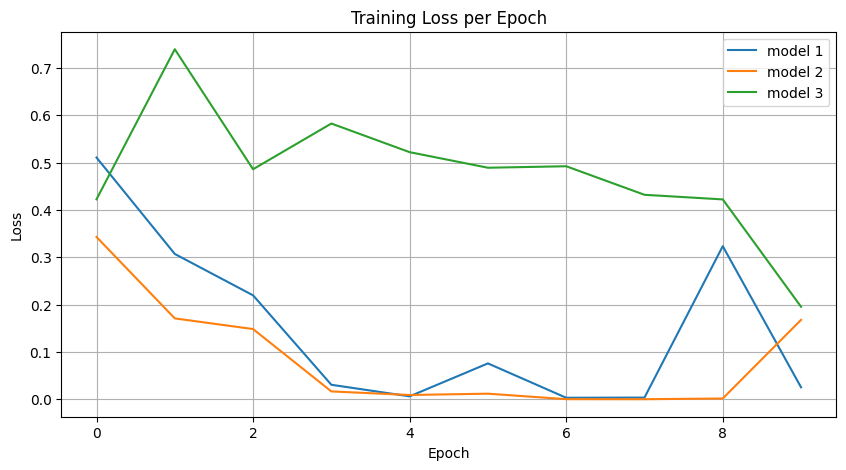

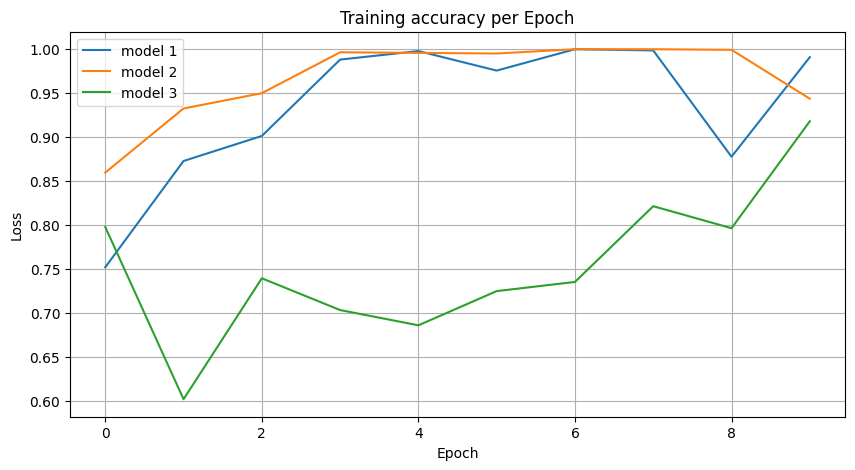

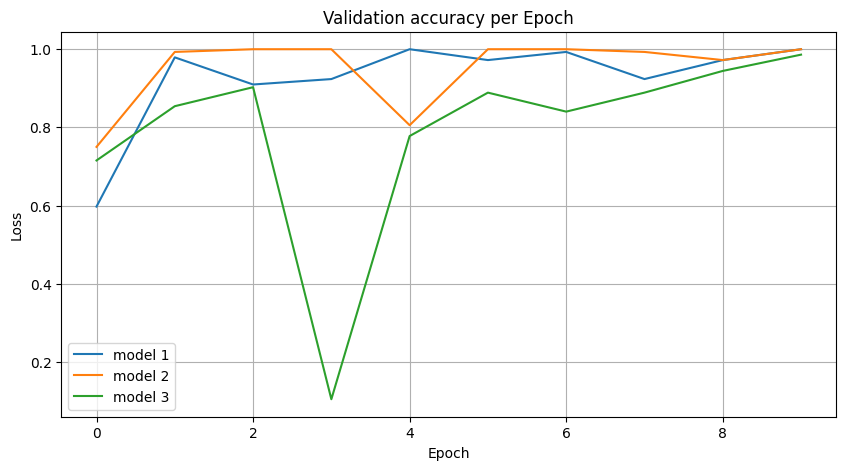

In [10]:
tuning_df = pd.read_csv('/kaggle/input/tuning-csv/tuning_df.csv')

#subset = tuning_df[tuning_df['test_accuracy'] >= 0.992]
subset = tuning_df.iloc[[12, 1, 21],:]

model_list = ['model 1', 'model 2', 'model 3']


plt.figure(figsize=(10, 5))
for idx, (_, row) in enumerate(subset.iterrows()):
    losses = eval(row['train_losses'])  # Convert string back to list
    label = model_list[idx]
    plt.plot(losses, label=label)

plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
for idx, (_, row) in enumerate(subset.iterrows()):
    losses = eval(row['train_accuracies'])  # Convert string back to list
    label = model_list[idx]
    plt.plot(losses, label=label)
    
plt.title("Training accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for idx, (_, row) in enumerate(subset.iterrows()):
    losses = eval(row['val_accuracies'])  # Convert string back to list
    label = model_list[idx]
    plt.plot(losses, label=label)
    
plt.title("Validation accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Save weights of models 1 and 2

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_class = IntermediateFusionResNet
train_loader = train_loader_contrast

lr = 0.0005
wd = 0.0

model1 = model_class(num_classes=2).to(device)
optimizer = optim.SGD(model1.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_accuracies = train_model2(model1, train_loader, val_loader, epochs=10, device=device)
acc, _, _ = test_model(model1, test_loader, device)


Epoch [1/10] - Loss: 0.5327, Train Acc: 0.7306, Val Acc: 0.8819
Epoch [2/10] - Loss: 0.3472, Train Acc: 0.8493, Val Acc: 0.9583
Epoch [3/10] - Loss: 0.1453, Train Acc: 0.9410, Val Acc: 0.9444
Epoch [4/10] - Loss: 0.0239, Train Acc: 0.9910, Val Acc: 0.9861
Epoch [5/10] - Loss: 0.1279, Train Acc: 0.9514, Val Acc: 1.0000
Epoch [6/10] - Loss: 0.3529, Train Acc: 0.8847, Val Acc: 0.9931
Epoch [7/10] - Loss: 0.1202, Train Acc: 0.9472, Val Acc: 1.0000
Epoch [8/10] - Loss: 0.0089, Train Acc: 0.9986, Val Acc: 1.0000
Epoch [9/10] - Loss: 0.0006, Train Acc: 1.0000, Val Acc: 1.0000
Epoch [10/10] - Loss: 0.0003, Train Acc: 1.0000, Val Acc: 1.0000
Test Accuracy: 0.9688


In [17]:
model_path = f"model1.pt"
torch.save(model1.state_dict(), model_path)

In [18]:
lr = 0.0001
wd = 0.0001

model2 = model_class(num_classes=2).to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr, weight_decay=wd)

criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_accuracies = train_model2(model2, train_loader, val_loader, epochs=10, device=device)
acc, _, _ = test_model(model2, test_loader, device)


Epoch [1/10] - Loss: 0.3314, Train Acc: 0.8625, Val Acc: 0.9375
Epoch [2/10] - Loss: 0.3963, Train Acc: 0.8292, Val Acc: 0.9375
Epoch [3/10] - Loss: 0.0904, Train Acc: 0.9660, Val Acc: 0.9861
Epoch [4/10] - Loss: 0.0083, Train Acc: 0.9972, Val Acc: 1.0000
Epoch [5/10] - Loss: 0.0521, Train Acc: 0.9896, Val Acc: 0.8542
Epoch [6/10] - Loss: 0.1146, Train Acc: 0.9646, Val Acc: 0.9861
Epoch [7/10] - Loss: 0.0026, Train Acc: 0.9993, Val Acc: 0.9861
Epoch [8/10] - Loss: 0.0410, Train Acc: 0.9875, Val Acc: 0.9722
Epoch [9/10] - Loss: 0.0022, Train Acc: 0.9993, Val Acc: 0.9722
Epoch [10/10] - Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.9722
Test Accuracy: 0.9740


In [19]:
model_path = f"model2.pt"
torch.save(model2.state_dict(), model_path)